In [1]:
import pandas as pd
import numpy as np

from pyspark.sql.functions import udf
from pyspark.sql.types import *
import warnings
warnings.filterwarnings("ignore")

import schemas
import tools
from tools import Aggregate, Spk

# Load Data
### Settlement

In [2]:
# initialise sparkContext\
spark = Spk()

In [3]:
 # to read parquet file
settlement = spark.load_parquet("data/ITU_DATA/settlement/2019.parquet", schemas.settlement_schema)
settlement = settlement.dropna(subset =["VAERDI"]) \
            .withColumn("VAERDI", settlement["VAERDI"].cast("float"))
            # .where("TIME_CET like '%:00:%'")
settlement.persist()
settlement.printSchema()

root
 |-- GSRN: string (nullable = true)
 |-- VAERDI: float (nullable = true)
 |-- TIME_CET: string (nullable = true)



### Weather
from ENetNEA, wind speed, wind direction

In [4]:
ws10_dic = spark.load_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_speed_10m.parquet")
ws100_dic = spark.load_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_speed_100m.parquet")
wd10_dic = spark.load_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_direction_10m.parquet")
wd100_dic = spark.load_weather_toPandas("data/ITU_DATA/prognosis/ENetNEA/wind_direction_100m.parquet")

In [5]:
aggs = Aggregate(ws10_dic, ws100_dic, wd10_dic, wd100_dic)

## Windmills

In [14]:
windmill = spark.load_windmill("data/windmill_cleaned.csv", schemas.windmills_schema)
windmill = windmill.where("grid != 0") \
            .fillna(0.1) \
            .withColumn("Turbine_type", aggs.udf_type(windmill.Turbine_type)) \
            .withColumn("Placement", aggs.udf_placement(windmill.Placement))
windmill.persist()
windmill.printSchema()

root
 |-- GSRN: string (nullable = true)
 |-- Turbine_type: float (nullable = true)
 |-- Parent_GSRN: string (nullable = true)
 |-- BBR_municipal: string (nullable = true)
 |-- Placement: float (nullable = true)
 |-- UTM_x: string (nullable = true)
 |-- UTM_y: string (nullable = true)
 |-- Capacity_kw: float (nullable = false)
 |-- Rotor_diameter: float (nullable = false)
 |-- Navhub_height: float (nullable = false)
 |-- grid: string (nullable = true)
 |-- grid_in_range: string (nullable = true)
 |-- Land_cover: float (nullable = false)
 |-- Slope: float (nullable = false)
 |-- roughness: float (nullable = false)



# Geo Impact Analysis

In [7]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

In [40]:

def kmeans_optimal(df, cols, k1, k2):
    vec_assembler = VectorAssembler(inputCols=cols, outputCol="features")
    dfk = vec_assembler.transform(df)

    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
    scalerModel = scaler.fit(dfk)
    dfk = scalerModel.transform(dfk)

    cost = []
    clusters = []

    for k in range(k1, k2):
        kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=5)
        model = kmeans.fit(dfk)
        cost.append(model.computeCost(dfk))
        clusters.append(k)

    # Plot the cost
    df_cost = pd.DataFrame(cost)
    df_cost.columns = ["cost"]
    df_cost.insert(0, 'cluster', clusters)

    return df_cost

In [36]:
import pylab as pl
def elbow_plot(df):
    pl.figure(figsize=(10,6))
    pl.plot(df.cluster, df.cost)
    pl.xticks(range(min(df.cluster), max(df.cluster)))
    pl.xlabel('Number of Clusters')
    pl.ylabel('Score')
    pl.title('Elbow Curve')
    pl.show()

## Clustering of windmills without Geodata

In [41]:
feat_cols = ["Turbine_type", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height"]
df_cost = kmeans_optimal(windmill, feat_cols, 10, 50)

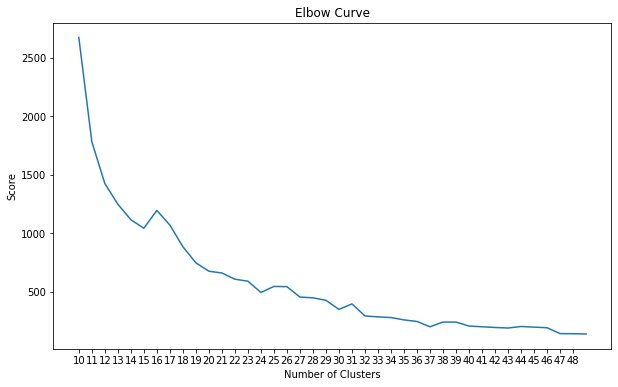

In [42]:
elbow_plot(df_cost)

## Clustering of windmills with Geodata

In [43]:
feat_cols = ["Turbine_type", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height", "Slope", "roughness"]
df_cost = kmeans_optimal(windmill, feat_cols, 10, 50)

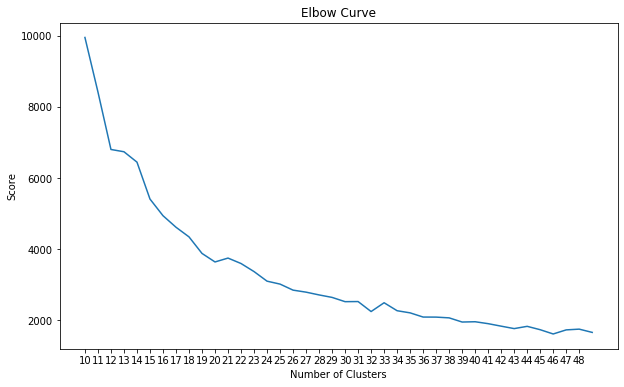

In [44]:
elbow_plot(df_cost)

In [ ]:
kmean = KMeans(featuresCol='scaledFeatures', k=35, seed=1)
model = kmean.fit(windmill)
windmill = model.transform(windmill).withColumnRenamed("prediction", "cluster").select("GSRN", "cluster","Navhub_height", "grid")
windmill.persist()

In [ ]:
windmill.show()

## Predicte with Weather